# A neuron with calcium dynamics and spike-frequency adaptation due to a Ca2+-activated K+ channel

**Calcium is good for you!**
![image](https://media.istockphoto.com/photos/glass-of-milk-picture-id1206080627?k=20&m=1206080627&s=612x612&w=0&h=NfdmNI8WYa5Kd7zMCqpZ8hFkakQCWzkv9aD9r5yhdRw=)

## Step 1: Setup

In [1]:
# Setup inline plotting
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# For Google Colab, this line installs NEURON
!pip install neuron quantities

In [3]:
# We will let this library handle unit conversion for us
import quantities as pq
from quantities import um, nS, mV, cm, ms, nA, S, uF, Hz, degrees, s

In [4]:
# Import and initialize NEURON
import neuron
from neuron import h
h.load_file("stdrun.hoc")

1.0

In [5]:
# Import other modules we need
import numpy as np

## Step 2: Define the circuit
We will use a single compartment, called a "Section" (more on that in next lectures). <br>
It has a cylindrical geometry with length "L" and a diameter "diam", and a specific capacitance "cm" (capacitance per area) <br>
**Unit conversion is a common source of error, so we will be explicit with our units.** 

In [6]:
soma = h.Section()

### Query NEURON for the expected units for soma.L & soma.diam

In [7]:
[h.units(x) for x in ["L", "diam"]]

['um', 'um']

In [8]:
soma.L = 20 * um
soma.diam =  20 * um

In [9]:
volume = soma(0.5).volume() * um**3

In [10]:
area = soma(0.5).area() * um**2

In [11]:
area

array(1256.63706144) * um**2

In [12]:
volume

array(6283.18530718) * um**3

### Assign the membrane capacitance "everywhere"

In [13]:
h.units("cm")  # Query the expected units

'uF/cm2'

In [14]:
specific_membrane_capacitance = 1 * uF/cm**2

In [15]:
for sec in soma.wholetree():
    sec.cm = specific_membrane_capacitance #  specific membrane capacitance (micro Farads / cm^2)
    sec.Ra = 100

### Add transient Na+, delayed rectified K+, leak

In [16]:
# This model includes the transient Na+, persistent K+ and the leak conductances
soma.insert("pas")
soma.insert("NaTg")
soma.insert("K_Pst")

__nrnsec_0x2b1dea0

In [17]:
h.celsius = 34

In [34]:
soma(0.5).K_Pst.gK_Pstbar = 0.2
soma(0.5).NaTg.gNaTgbar = 0.42

### Parametize the leak conductance G = 1/R

In [19]:
G = 2.0 * nS  # R = 1/G in our RC circuit

In [20]:
v_rest = -70*mV

In [21]:
tau_m = (specific_membrane_capacitance * area / G).rescale(ms)

In [22]:
# Assign the leak conductance everywhere
for seg in soma:
    seg.pas.g = (G/area).rescale(S/cm**2)  # Compute specific conductance, and rescale to units of 'S/cm2'
    seg.pas.e = -70.0

In [23]:
tau_m = ((soma(0.5).cm * uF/cm**2) / (soma(0.5).pas.g * S/cm**2)).rescale(ms)

In [24]:
tau_m

array(6.28318531) * ms

### Inspect our parameters

In [25]:
soma.psection()

{'point_processes': {},
 'density_mechs': {'pas': {'g': [0.00015915494309189538],
   'e': [-70.0],
   'i': [0.0]},
  'K_Pst': {'gK_Pstbar': [0.2],
   'ik': [0.0],
   'gK_Pst': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'NaTg': {'gNaTgbar': [0.22],
   'vshifth': [0.0],
   'vshiftm': [0.0],
   'slopeh': [6.0],
   'slopem': [6.0],
   'ina': [0.0],
   'gNaTg': [0.0],
   'm': [0.0],
   'h': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]},
  'ttx': {'ettx': [0.0],
   'ttxi': [1.0],
   'ttxo': [1.0],
   'ittx': [0.0],
   'dittx_dv_': [0.0]}},
 'morphology': {'L': 20.0,
  'diam': [20.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 100.0,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': '__nrnsec_0x2b1dea0',
 'hoc_internal_name': '__nrnsec_0x2b1dea0',
 'cell': None}

In [26]:
soma.nseg

1

### Add a current injection

In [27]:
stim = h.IClamp(soma(0.5))

In [28]:
stim.delay = 200 * ms  # Inject current 500ms after the start of the simulation 
stim.dur = 600 * ms  # stop injecting current at 520ms 
stim.amp = 0.025 * nA  # Inject 0.1 nA of current

## Step 3: Run the simulation

### Define recordings of simulation variables

In [29]:
soma_v = h.Vector().record(soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

### Run the simulation

In [35]:
h.finitialize( float(v_rest) )
h.continuerun( float(1000 * ms) )

0.0

## Step 4: Plot the results

(array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,   60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

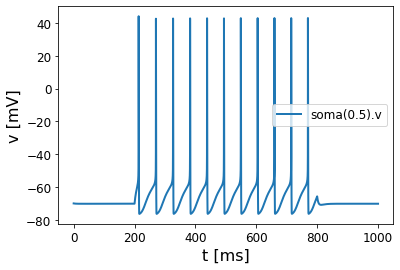

In [36]:
plt.plot(t, soma_v, lw=2, label="soma(0.5).v")
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
#plt.axis([0,1000,-80,50])

In [37]:
def find_spikes(v, t):
    """ Returns times of spikes for a voltage trace and time grid"""
    # look for upward crossing of 0mV
    v_arr = np.array(v)
    t_arr = np.array(t) 
    # This is tricky & powerful notation! Let's discuss in class!
    return t_arr[1:][(v_arr[1:]>0) & (v_arr[:-1]<0)] 

In [38]:
I_range = np.arange(0,0.15,0.005)

In [39]:
def find_freq(I):
    stim.amp = I
    h.finitialize( float(v_rest) )
    h.continuerun( float(1000 * ms) )
    spike_times = find_spikes(soma_v, t)
    firing_freq = (len(spike_times)/(stim.dur*ms)).rescale(Hz)
    return firing_freq

In [40]:
# Note this cool notation: List comprehension
freqs = [find_freq(x) for x in I_range]

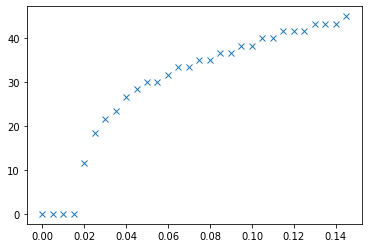

In [41]:
plt.plot(I_range, freqs, 'x')
#plt.axis([0.01, 0.02, 0, 100])

In [100]:
#soma.uninsert("K_Tst")
#soma(0.5).K_Tst.gK_Tstbar = 0.0

## Adding calcium dynamics

### 1) Add extrusion and buffering

In [45]:
soma.insert("CaDynamics_DC0")

__nrnsec_0x2b1dea0

In [46]:
soma(0.5).CaDynamics_DC0.decay = 100

### Add the calcium channels

In [47]:
soma.insert("Ca_HVA2")

__nrnsec_0x2b1dea0

In [57]:
soma(0.5).Ca_HVA2.gCa_HVAbar = 0.005

In [ ]:
#soma.insert("Ca_LVAst")

In [ ]:
#soma(0.5).Ca_LVAst.gCa_LVAstbar = 0.0

### Insert an SK-type Ca2+ activated potassium channel

In [50]:
soma.insert("SK_E2")

__nrnsec_0x2b1dea0

In [62]:
soma(0.5).SK_E2.gSK_E2bar = 0.02

### Record the calcium and SK conductance

In [52]:
cai = h.Vector().record(soma(0.5)._ref_cai)
gske2 = h.Vector().record(soma(0.5).SK_E2._ref_gSK_E2 )

In [72]:
# Watch out for units
h.units("cai")

'mM'

In [73]:
stim.amp = 1.0 * nA  # Inject 0.1 nA of current

In [74]:
h.finitialize( float(v_rest) )
h.continuerun( float(1000 * ms) )

0.0

(array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

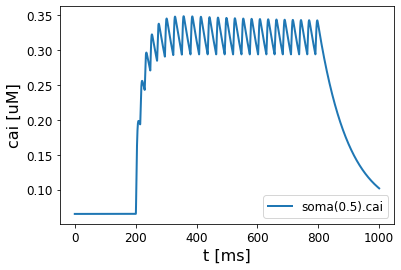

In [75]:
plt.plot(t, cai*1000, lw=2, label="soma(0.5).cai")
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("cai [uM]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
#plt.axis([100,200,-80,30])

(array([-0.001,  0.   ,  0.001,  0.002,  0.003,  0.004,  0.005,  0.006]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

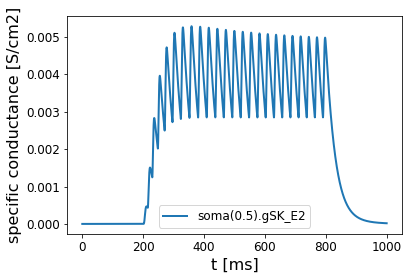

In [77]:
plt.plot(t, gske2, lw=2, label="soma(0.5).gSK_E2")
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("specific conductance [S/cm2]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
#plt.axis([100,200,-80,30])

(100.0, 500.0, -80.0, 50.0)

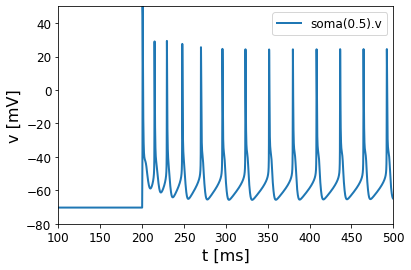

In [78]:
plt.plot(t, soma_v, lw=2, label="soma(0.5).v")
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.axis([100,500,-80,50])

## Now it's your turn!

### **Question 1** 
Create a function to return the firing frequency as 1/inter-spike interval for a given current input I, and plot the firing frequency for a range of currents 

Now compare that firing frequencies computed from the 1st, 2nd or last inter-spike interval

What is the role of the SK channel? What happens if it is blocked (g = 0)?

